In [35]:
import s3fs
import boto3
import time

from PIL import Image
import numpy as np
import hashlib
import io
import json
import gc
from tqdm import tqdm
import pandas as pd
import os

import torch
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score

In [36]:
def init_clients():
    return boto3.client("s3"), s3fs.S3FileSystem()

boto3_s3, s3fs_ = init_clients()

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
# device = 'cpu'
print()

Using device: cuda



In [38]:
def read_zoom_in():
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv('ZOOMIN.csv')
    del df['Unnamed: 0']
    train_x, test_x, train_y, test_y = train_test_split(df['img_path'], df['label'], test_size=0.3, random_state=42,stratify=df['label'])
    train_x, test_x, train_y, test_y =  train_x[:4000], test_x[:1000], train_y[:4000], test_y[:1000]
    return np.array(train_x), np.array(test_x), np.array(train_y), np.array(test_y)

def read_csv_file():
    df = pd.read_csv('compcars-angle.csv')
    del df['Unnamed: 0']
    train_x, test_x, train_y, test_y = train_test_split(df['img_path'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])
    train_x, test_x, train_y, test_y = train_x[:12000], test_x[:3661], train_y[:12000], test_y[:3661]
    train_x_2, test_x_2, train_y_2, test_y_2 = read_zoom_in()
    train_x = np.concatenate((train_x, train_x_2))
    train_y = np.concatenate((train_y, train_y_2))
    test_x = np.concatenate((test_x, test_x_2))
    test_y = np.concatenate((test_y, test_y_2))
    return np.array(train_x), np.array(test_x), np.array(train_y), np.array(test_y)


In [39]:
# def total_data():
#     with open('front.json', 'r') as file:
#         front = json.load(file)
#     with open('rear.json', 'r') as file:
#         rear = json.load(file)
#     with open('side_lr.json', 'r') as file:
#         side = json.load(file)
#     with open('rear_lr.json', 'r') as file:
#         rear_lr = json.load(file)
#     with open('front_lr.json', 'r') as file:
#         front_lr = json.load(file)
#     new_data = front
#     new_data.update(rear)
#     new_data.update(side)
#     new_data.update(rear_lr)
#     new_data.update(front_lr)
#     x = list(new_data.keys())
#     y = list(new_data.values())
#     train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
#     train_x_2, test_x_2, train_y_2, test_y_2 = read_zoom_in()
#     train_x = np.concatenate((train_x, train_x_2))
#     train_y = np.concatenate((train_y, train_y_2))
#     test_x = np.concatenate((test_x, test_x_2))
#     test_y = np.concatenate((test_y, test_y_2))
#     return train_x, test_x,train_y,test_y

In [53]:
# train_x, test_x,train_y,test_y = total_data()
# Counter(train_y)

In [41]:
def preprocess_image(image_bytes, byte=True):
    # Open the image as bytes
    if byte is True:
        image = Image.open(io.BytesIO(image_bytes))
    if byte is False:
        image = Image.open(image_bytes)
    # Convert to grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to numpy array
    image_np = np.array(image)

    # Convert the numpy array to PyTorch tensor
    image_tensor = torch.tensor(image_np)

    # Convert the tensor to 3D RGB (if it's not already)
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

    # Normalize to [0, 1]
    image_tensor = image_tensor.float() / 255.0

    return image_tensor


def process_duplicates_image_ids(image_paths: list, batch_size: int,
                                 bucket: str, boto_s3: boto3.client("s3"), 
                                 s3fs_: s3fs.S3FileSystem(), target_size=(256, 256)):
    image_tensors = []
    for i in tqdm(range(0, len(image_paths), batch_size), total=len(image_paths)//batch_size, desc='Processing Images'):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_image_tensors = []
        for ad_image in batch_image_paths:
            if ad_image.lower().startswith("dpgos-osdata-boaz-beukers-sandbox"):
                image_path = "/".join(ad_image.split("/")[1:])
                s3_object = boto_s3.get_object(Bucket=bucket, Key=image_path)
                image_bytes = s3_object['Body'].read()
                image_tensor = preprocess_image(image_bytes,True)
                batch_image_tensors.append(image_tensor)
            if os.path.isfile(ad_image) and ad_image.lower().startswith("datasets/"):
                image_tensor = preprocess_image(ad_image,False)
                batch_image_tensors.append(image_tensor)
        # Resize or crop images to the target size before stacking
        batch_image_tensors_resized = [transforms.functional.resize(image, target_size) for image in batch_image_tensors]
        image_tensors.append(torch.stack(batch_image_tensors_resized))

    # Concatenate processed batches
    processed_image_tensors = torch.cat(image_tensors, dim=0)

    # Display the shape and dtype of the tensor
    print("Tensor Shape:", processed_image_tensors.shape)
    print("Tensor Dtype:", processed_image_tensors.dtype)

    return processed_image_tensors

In [42]:
def fit_train_embeddings(im_train,train_y):
    start_time = time.time()

    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights).to(device)
    model.eval()


    data_loader = DataLoader(im_train, batch_size=32, shuffle=False)
    embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            embedding_batch = model(batch)
            embeddings.append(embedding_batch)

    train_embeddings = torch.cat(embeddings, dim=0).cpu().numpy()
    print('Fitting in progress:')
    svm_classifier = SVC(kernel='rbf', random_state=42)
    svm_classifier.fit(train_embeddings, train_y)
    print('Fitting done:')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return svm_classifier

In [43]:
def predict_test_embeddings(im_test,svm_classifier):
    start_time = time.time()

    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights).to(device)
    model.eval()


    data_loader = DataLoader(im_test, batch_size=32, shuffle=False)
    embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            embedding_batch = model(batch)
            embeddings.append(embedding_batch)

    embeddings_test = torch.cat(embeddings, dim=0).cpu().numpy()
    y_pred = svm_classifier.predict(embeddings_test)
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return y_pred

In [54]:
def show_matrix(test_y_svm,y_pred,filename=None):
    print(classification_report(test_y_svm, y_pred))
    cm = confusion_matrix(test_y_svm, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['front','rear','side','front-side','rear-side','zoom-in'])
    disp.plot()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
# def show_matrix(test_y_svm,y_pred,filename=None):
#     print(classification_report(test_y_svm, y_pred))
#     cm = confusion_matrix(test_y_svm, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['front','rear','front-left','front-right','rear-right','rear-left','side-left','side-right','zoom-in'])
#     disp.plot()
#     if filename:
#         plt.savefig(filename)
#     else:
#         plt.show()

In [62]:
def trained_SVM():
    train_x, test_x, train_y, test_y = read_csv_file()
    gc.collect()
    im_train = process_duplicates_image_ids(image_paths=train_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)
    im_test = process_duplicates_image_ids(image_paths=test_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)
#     for i in range(5):
    svm_classifier = fit_train_embeddings(im_train,train_y)
    result = predict_test_embeddings(im_test,svm_classifier)
    show_matrix(test_y,result,filename='trained_SVM_classifier_angle.png')


Processing Images:   0%|          | 0/147 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images: 148it [19:02,  7.72s/it]                         


Tensor Shape: torch.Size([14789, 3, 256, 256])
Tensor Dtype: torch.float32


Processing Images: 57it [05:59,  6.31s/it]                        


Tensor Shape: torch.Size([5624, 3, 256, 256])
Tensor Dtype: torch.float32


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


Fitting in progress:
Fitting done:
Time taken for training: 104.77681875228882 seconds
Time taken for testing: 70.94884514808655 seconds
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       617
           1       0.95      0.96      0.96       464
           5       0.99      0.99      0.99      1000
           6       0.51      0.87      0.65       964
           7       0.47      0.11      0.18       740
           8       0.53      0.33      0.41       484
           9       0.55      0.61      0.58       570
          10       0.55      0.89      0.68       472
          11       0.38      0.03      0.05       313

    accuracy                           0.69      5624
   macro avg       0.65      0.64      0.60      5624
weighted avg       0.67      0.69      0.64      5624



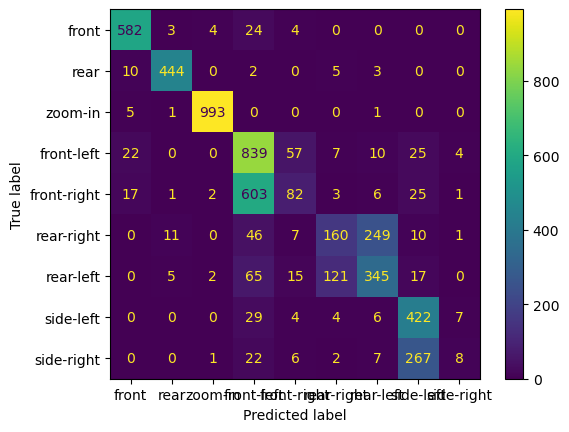

In [63]:
trained_SVM()

In [45]:
# def total_data_bin():
# #     with open('front.json', 'r') as file:
# #         front = json.load(file)
# #     with open('rear.json', 'r') as file:
# #         rear = json.load(file)
# #     with open('side_lr.json', 'r') as file:
# #         side = json.load(file)
# #     with open('rear_lr.json', 'r') as file:
# #         rear_lr = json.load(file)
#     with open('front_lr.json', 'r') as file:
#         front_lr = json.load(file)
#     new_data = front_lr
# #     new_data.update(rear)
# #     new_data.update(side)
# #     new_data.update(rear_lr)
# #     new_data.update(front_lr)
#     x = list(new_data.keys())
#     y = list(new_data.values())
#     train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
# #     train_x_2, test_x_2, train_y_2, test_y_2 = read_zoom_in()
# #     train_x = np.concatenate((train_x, train_x_2))
# #     train_y = np.concatenate((train_y, train_y_2))
# #     test_x = np.concatenate((test_x, test_x_2))
# #     test_y = np.concatenate((test_y, test_y_2))
#     return train_x, test_x,train_y,test_y

In [55]:
# from PIL import Image, ImageOps

# with open('front_lr.json', 'r') as file:
#         front_lr = json.load(file)
# new_data = front_lr
# x = list(new_data.keys())
# y = list(new_data.values())
# # x = x[:10]
# # y= y[:10]
# y = [0 if x == 6 else x for x in y]
# y = [1 if x == 7 else x for x in y]


# x_embd = process_duplicates_image_ids(image_paths=x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
#     boto_s3=boto3_s3,
#     s3fs_=s3fs_,target_size=(384, 384))

# index_fl = [i for i, x in enumerate(y) if x == 0]
# index_fr = [i for i, x in enumerate(y) if x == 1]

# x_front_left = []
# x_front_right = []
# y_mirr_fl = []
# y_mirr_fr = []
# for index in index_fl:
#     x_front_left.append(x[index])
# for index in index_fr:
#     x_front_right.append(x[index])
# image_tensors = []

# # Load the image
# for im in x_front_left:
#     image = Image.open(im)
#     if image.mode != 'RGB':
#         image = image.convert('RGB')
#     flipped_image = ImageOps.mirror(image)
#     # Convert image to numpy array
#     image_np = np.array(flipped_image)

#     # Convert the numpy array to PyTorch tensor
#     image_tensor = torch.tensor(image_np)

#     # Convert the tensor to 3D RGB (if it's not already)
#     if len(image_tensor.shape) == 2:
#         image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
#     image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

#     # Normalize to [0, 1]
#     image_tensor = image_tensor.float() / 255.0
#     batch_image_tensors_resized = transforms.functional.resize(image_tensor, (384, 384))
#     image_tensors.append(batch_image_tensors_resized)
#     y_mirr_fl.append(1)
# mirrored_fl = torch.stack(image_tensors)
# print("Tensor Shape:", mirrored_fl.shape)
# print("Tensor Dtype:", mirrored_fl.dtype)
# image_tensors = []

# # Load the image
# for im in x_front_right:
#     image = Image.open(im)
#     if image.mode != 'RGB':
#         image = image.convert('RGB')
#     flipped_image = ImageOps.mirror(image)
#     # Convert image to numpy array
#     image_np = np.array(flipped_image)

#     # Convert the numpy array to PyTorch tensor
#     image_tensor = torch.tensor(image_np)

#     # Convert the tensor to 3D RGB (if it's not already)
#     if len(image_tensor.shape) == 2:
#         image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
#     image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

#     # Normalize to [0, 1]
#     image_tensor = image_tensor.float() / 255.0
#     batch_image_tensors_resized = transforms.functional.resize(image_tensor, (384, 384))
#     image_tensors.append(batch_image_tensors_resized)
#     y_mirr_fr.append(0)
# mirrored_fr = torch.stack(image_tensors)
# print("Tensor Shape:", mirrored_fr.shape)
# print("Tensor Dtype:", mirrored_fr.dtype)

# y.extend(y_mirr_fl)
# y.extend(y_mirr_fr)

# x = torch.cat([x_embd,mirrored_fl,mirrored_fr],dim=0)
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [47]:
len(test_y)

3410

In [56]:
class CustomDataset(Dataset):
    def __init__(self, images, targets, num_classes):
        self.images = images
        self.targets = targets
        self.num_classes = num_classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # Convert target label to one-hot encoded tensor
        one_hot_target = torch.zeros(self.num_classes)
        one_hot_target[target] = 1

        return image, one_hot_target

def dataloader(train_x, train_y, test_x, test_y,num_classes):
    train_images, val_images, train_targets, val_targets = train_test_split(train_x, train_y, test_size=0.3, random_state=42, stratify=train_y)

    train_dataset = CustomDataset(train_images, train_targets,num_classes)
    val_dataset = CustomDataset(val_images, val_targets,num_classes)
    
    test_dataset = CustomDataset(test_x, test_y,num_classes)

    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
    
    return train_loader, val_loader, test_loader


# Plan

Nu word er een pretrained resnet50 gebruikt voor word embeddings, wat als we dat model ook nog trainen

In [19]:
def read_zoom_in_tr():
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv('ZOOMIN.csv')
    del df['Unnamed: 0']
    train_x, test_x, train_y, test_y = train_test_split(df['img_path'], df['label'], test_size=0.3, random_state=42,stratify=df['label'])
    train_x, test_x, train_y, test_y =  train_x[4000:4200], test_x[1000:1500], train_y[4000:4200], test_y[1000:1500]
    return np.array(train_x), np.array(test_x), np.array(train_y), np.array(test_y)

def data_trained_resnet():
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv('compcars-angle.csv')
    del df['Unnamed: 0']
    train_x, test_x, train_y, test_y = train_test_split(df['img_path'], df['label'], test_size=0.3, random_state=42,stratify=df['label'])
    train_x, test_x, train_y, test_y =  train_x[30000:35000], test_x[4000:5000], train_y[30000:35000], test_y[4000:5000]
    train_x_2, test_x_2, train_y_2, test_y_2 = read_zoom_in_tr()
    train_x = np.concatenate((train_x, train_x_2))
    train_y = np.concatenate((train_y, train_y_2))
    test_x = np.concatenate((test_x, test_x_2))
    test_y = np.concatenate((test_y, test_y_2))
    return np.array(train_x), np.array(test_x), np.array(train_y), np.array(test_y)




In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, images, targets, num_classes):
        self.images = images
        self.targets = targets
        self.num_classes = num_classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # Convert target label to one-hot encoded tensor
        one_hot_target = torch.zeros(self.num_classes)
        one_hot_target[target] = 1

        return image, one_hot_target

def dataloader(train_x, train_y, num_classes):
    train_images, val_images, train_targets, val_targets = train_test_split(train_x, train_y, test_size=0.3, random_state=42,stratify=train_y)

    train_dataset = CustomDataset(train_images, train_targets, num_classes)
    val_dataset = CustomDataset(val_images, val_targets, num_classes)
    
    train_batch_size = 32
    val_batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size)
    
    return train_loader, val_loader


In [21]:
def train_trainedResNet(epochs, train_loader, val_loader):
    start_time = time.time()

    model = resnet50(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False   

    model.fc = nn.Sequential(
        nn.Linear(2048, 6)  # Output layer with 6 units for multi-class classification
    ).to(device)
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
    optimizer = optim.Adam(model.fc.parameters())

    num_epochs = epochs
    train_losses = []
    validation_losses = []

    best_validation_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets).to(device)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_loss = 0.0
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, targets).to(device)
                train_loss += val_loss.item()

        train_loss /= len(val_loader)
        validation_loss = val_loss.item()

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {validation_loss}')

    plt.plot(range(1, num_epochs + 1), train_losses, label='Training set')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation set')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and validation loss trained ResNet50 with SVM')
    plt.legend()
    plt.savefig('training_validation_figure.png')
    plt.show()

    torch.save(best_model_state, 'model_trainedresnetsvm_angle.pth')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return best_model_state, model


In [22]:
def emb_trained_model(best_model_state, model,im_train,train_y):
    start_time = time.time()

    model.load_state_dict(best_model_state)
    model.eval()


    data_loader = DataLoader(im_train, batch_size=32, shuffle=False)
    embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            embedding_batch = model(batch)
            embeddings.append(embedding_batch)

    train_embeddings = torch.cat(embeddings, dim=0).cpu().numpy()
    print('Fitting in progress:')
    svm_classifier = SVC(kernel='rbf', random_state=42)
    svm_classifier.fit(train_embeddings, train_y)
    print('Fitting done:')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return svm_classifier

In [23]:
def trainedmodel_test_embeddings(best_model_state, model,im_test,svm_classifier):
    start_time = time.time()

    model.load_state_dict(best_model_state)
    model.eval()
    data_loader = DataLoader(im_test, batch_size=32, shuffle=False)
    embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            embedding_batch = model(batch)
            embeddings.append(embedding_batch)

    embeddings_test = torch.cat(embeddings, dim=0).cpu().numpy()
    y_pred = svm_classifier.predict(embeddings_test)
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return y_pred

In [24]:
def doubletrouble_SVM():
    train_x, test_x, train_y, test_y = data_trained_resnet()
    gc.collect()
    im_train = process_duplicates_image_ids(image_paths=train_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)
    train_loader,val_loader = dataloader(im_train,train_y,6)

    best_model,model = train_trainedResNet(30, train_loader, val_loader)
    
    
    
    train_x, test_x, train_y, test_y = read_csv_file()
    gc.collect()
    im_train = process_duplicates_image_ids(image_paths=train_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)
    im_test = process_duplicates_image_ids(image_paths=test_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)
    for i in range(5):
        svm_classifier = emb_trained_model(best_model,model,im_train,train_y)
        result = trainedmodel_test_embeddings(best_model,model,im_test,svm_classifier)
        show_matrix(test_y,result,filename='trainedResNet_SVM_classifier_angle.png')
        

Processing Images:   0%|          | 0/52 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images: 100%|██████████| 52/52 [04:39<00:00,  5.37s/it]


Tensor Shape: torch.Size([5200, 3, 256, 256])
Tensor Dtype: torch.float32


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 0.673089051125001, Val Loss: 0.5614669919013977
Epoch 2/30, Train Loss: 0.5041033814148027, Val Loss: 0.455841064453125
Epoch 3/30, Train Loss: 0.4621688139681913, Val Loss: 0.4119729995727539
Epoch 4/30, Train Loss: 0.40403904598586415, Val Loss: 0.39065369963645935
Epoch 5/30, Train Loss: 0.39113302133521255, Val Loss: 0.3779106140136719
Epoch 6/30, Train Loss: 0.3790880158847692, Val Loss: 0.3891568183898926
Epoch 7/30, Train Loss: 0.43287709203301644, Val Loss: 0.3392978608608246
Epoch 8/30, Train Loss: 0.36685799974568034, Val Loss: 0.3255005478858948
Epoch 9/30, Train Loss: 0.39137234888514694, Val Loss: 0.46836501359939575
Epoch 10/30, Train Loss: 0.3667522906040659, Val Loss: 0.38401421904563904
Epoch 11/30, Train Loss: 0.35977157463832776, Val Loss: 0.40663671493530273
Epoch 12/30, Train Loss: 0.36773086126361576, Val Loss: 0.4375308156013489
Epoch 13/30, Train Loss: 0.35430730879306793, Val Loss: 0.3673991858959198
Epoch 14/30, Train Loss: 0.3517994362

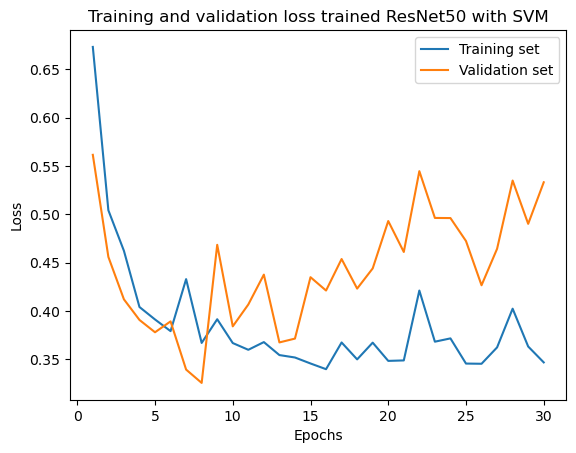

Time taken for training: 549.0530745983124 seconds


Processing Images:   0%|          | 0/160 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images: 100%|██████████| 160/160 [05:22<00:00,  2.02s/it]


Tensor Shape: torch.Size([16000, 3, 256, 256])
Tensor Dtype: torch.float32


Processing Images: 47it [01:23,  1.78s/it]                        


Tensor Shape: torch.Size([4661, 3, 256, 256])
Tensor Dtype: torch.float32
Fitting in progress:
Fitting done:
Time taken for training: 55.03475093841553 seconds
Time taken for testing: 16.728880167007446 seconds
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       486
           1       0.91      0.93      0.92       356
           2       0.89      0.90      0.89       641
           3       0.88      0.90      0.89      1338
           4       0.88      0.85      0.86       840
           5       0.98      0.99      0.98      1000

    accuracy                           0.91      4661
   macro avg       0.91      0.91      0.91      4661
weighted avg       0.91      0.91      0.91      4661

Fitting in progress:
Fitting done:
Time taken for training: 55.41686964035034 seconds
Time taken for testing: 16.771518230438232 seconds
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       486


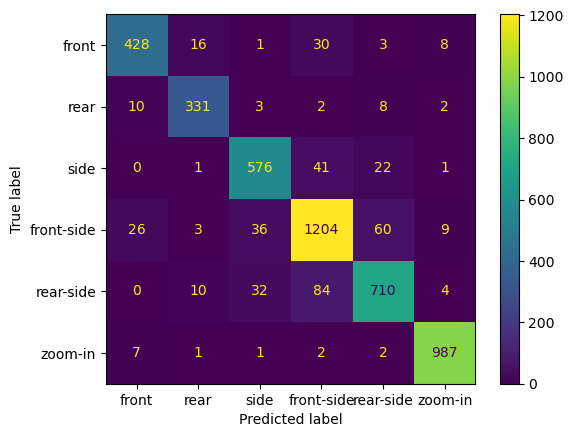

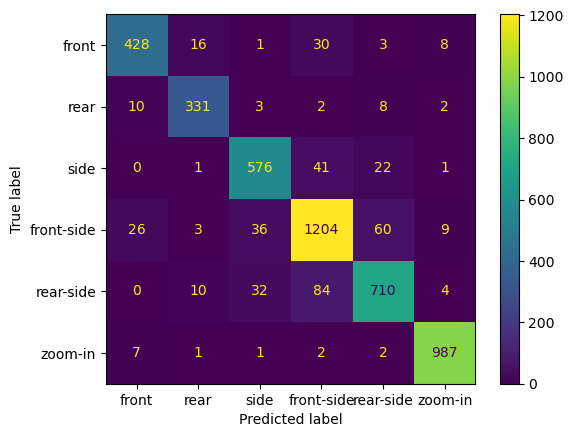

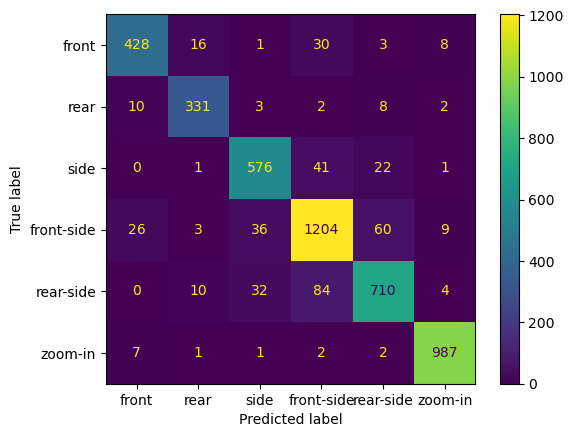

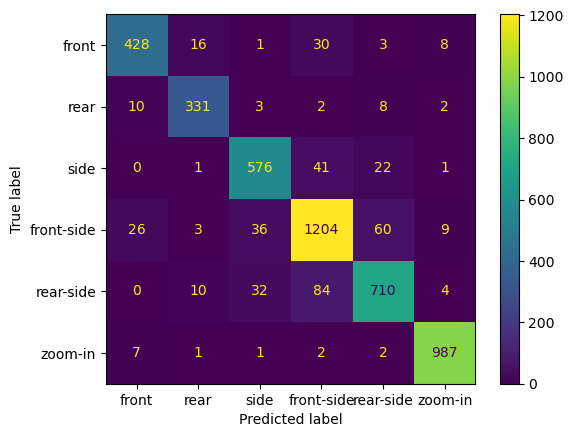

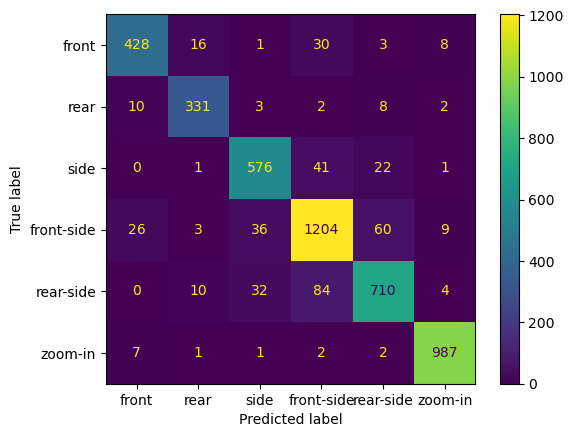

In [25]:
doubletrouble_SVM()